# Real Time data

Real-Time quality control is a set of automatic procedures that are performed at the National Data Acquisition Centers (DACs) to carry out the first quality control of the data. 
There are a total of 19 tests that aim, to say, easy to identify anomalies in the data. The subtle anomalies, that need a lot of expertise and time to discern between sensor malfunctioning and natural variability, are left for the Delayed-Mode quality control. 

The results of the Real-Time tests are summarized in what is called the **quality control flags**. Quality control flags are an essential part of Argo.

## Quality Control flags

Each observation after the RT quality control has a QC flag associated, a number from 0 to 9, with the following meaning:

|QCflag|Meaning|Real time description|
|:----:|:-----:|:-------------------:|
|0 |No QC performed|No QC performed|
|1 |Good data|All real time QC tests passed|
|2 |Probably good data|	Probably good|
|3 |Bad data that are potentially correctable|Test 15 or Test 16 or Test 17 failed and all other real-time QC tests passed. These  data are not to be used without scientific correction. A flag ‘3’ may be assigned by an operator during additional visual QC for bad |data that may be corrected in delayed mode.|
|4 |Bad data|Data have failed one or more of the real-time QC tests, excluding Test 16. A flag ‘4’ may be assigned by an operator during additional visual QC for bad data that are not correctable.|
|5 |Value changed|Value changed|
|6 |Not currently used |Not currently used|
|7 |Not currently used |Not currently used|
|8 |Estimated |Estimated value (interpolated, extrapolated or other estimation)|
|9 |Missing value|Missing value|

First, let's see how this information is stored in the NetCDF files

In [33]:
import numpy as np
import netCDF4
import xarray as xr

import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import pyplot as plt
%matplotlib inline

Before accesing the data, let's create some usefull colormaps and colorbar makers to help us to understand the QC flags

In [34]:
qcmap = mpl.colors.ListedColormap(['#000000', 
                                   '#31FC03', 
                                   '#ADFC03', 
                                   '#FCBA03', 
                                   '#FC1C03',
                                   '#324CA8', 
                                   '#000000', 
                                   '#000000', 
                                   '#B22CC9', 
                                   '#000000'])
def colorbar_qc(cmap, **kwargs):
    """Adjust colorbar ticks with discrete colors for QC flags"""
    ncolors = 10
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    return colorbar

## QC flags for data accessed by date
open the daily data set from the 11th november 2019

In [35]:
dayADS = xr.open_dataset('../../Data/atlantic_ocean/2020/11/20201111_prof.nc')

In [36]:
dayADS

<xarray.Dataset> Size: 21MB
Dimensions:                       (N_PROF: 188, N_PARAM: 3, N_LEVELS: 1331,
                                   N_CALIB: 3, N_HISTORY: 0)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB, N_HISTORY
Data variables: (12/64)
    DATA_TYPE                     object 8B ...
    FORMAT_VERSION                object 8B ...
    HANDBOOK_VERSION              object 8B ...
    REFERENCE_DATE_TIME           object 8B ...
    DATE_CREATION                 object 8B ...
    DATE_UPDATE                   object 8B ...
    ...                            ...
    HISTORY_ACTION                (N_HISTORY, N_PROF) object 0B ...
    HISTORY_PARAMETER             (N_HISTORY, N_PROF) object 0B ...
    HISTORY_START_PRES            (N_HISTORY, N_PROF) float32 0B ...
    HISTORY_STOP_PRES             (N_HISTORY, N_PROF) float32 0B ...
    HISTORY_PREVIOUS_VALUE        (N_HISTORY, N_PROF) float32 0B ...
    HISTORY_QCTEST                (N_HISTORY, N_PROF) object 0B ...
Attributes:
    title:                Argo float vertical profile
    institution:          FR GDAC
    source:               Argo float
    history:              2021-12-11T02:20:00Z creation
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  3.1
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile

Besides the core variables, TEMP, PSAL and PRES, we also have the variables TEMP_ADJUSTED, PSAL_ADJUSTED and PRES_ADJUSTED, which correspond to DM, or calibrated data. However, here we keep the focus on the Real-Time data, and in the next section, we will use the calibrated data.

Let's begin by plotting the location of all the data.

### Location

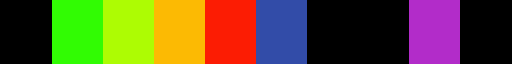

In [37]:
qcmap

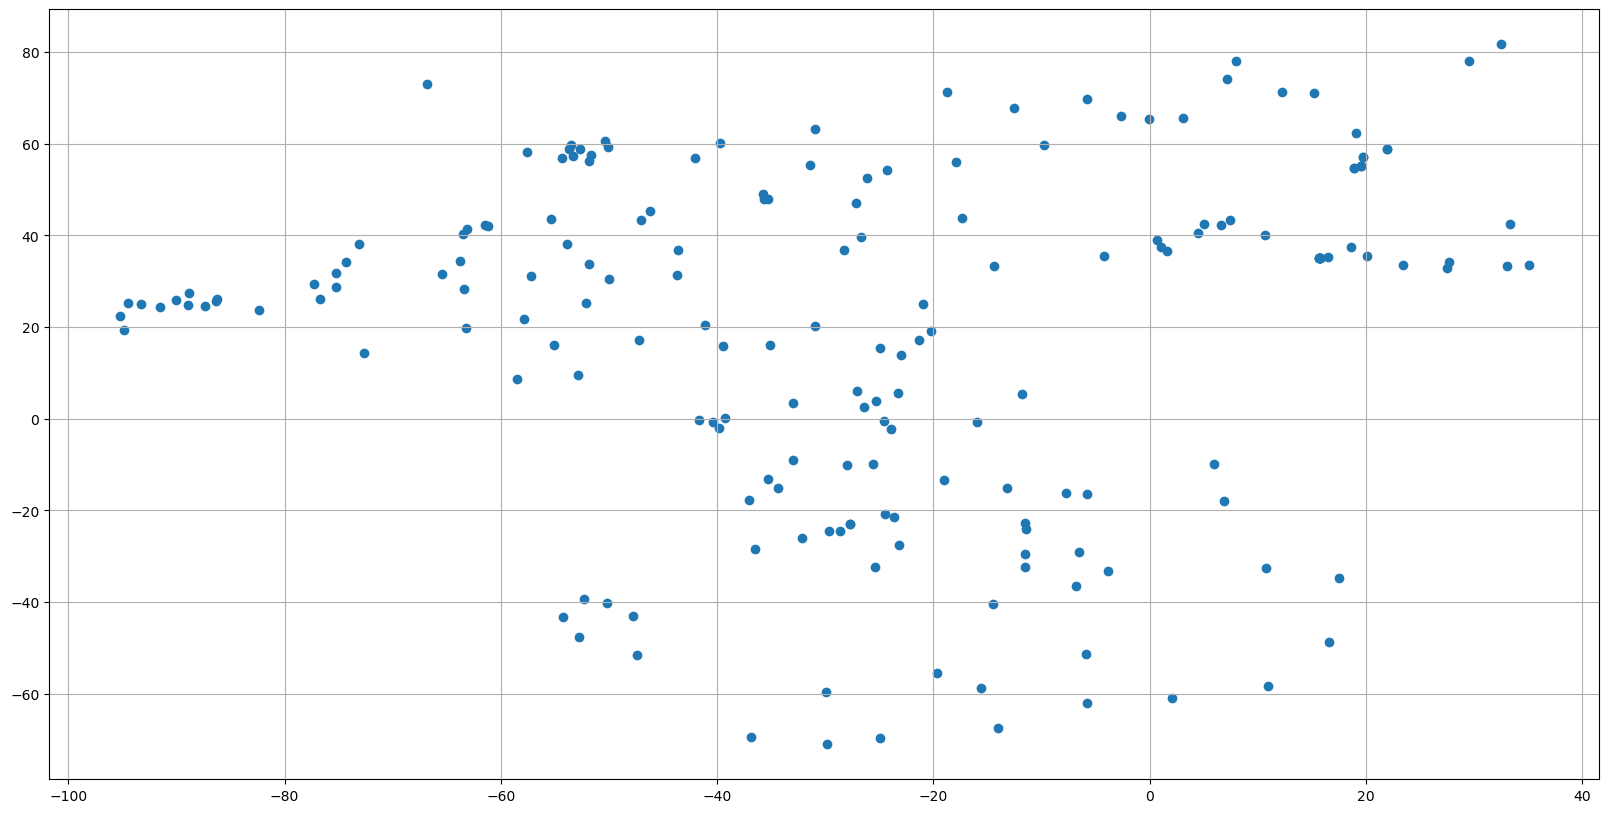

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
sc = ax.scatter(dayADS.LONGITUDE, dayADS.LATITUDE)
ax.grid()

If we want to get a better map, we need cartopy. 

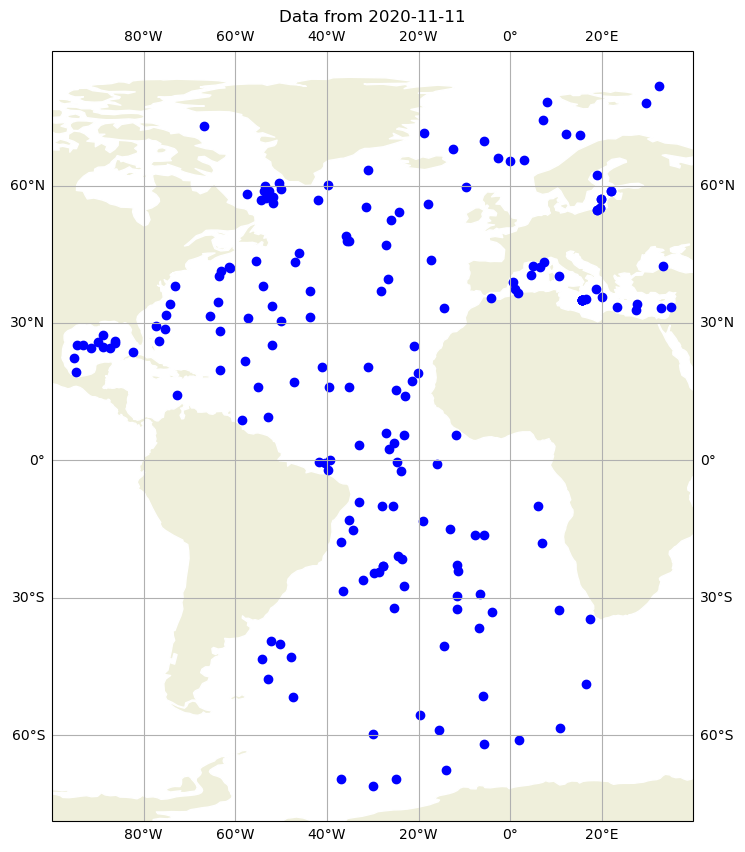

In [39]:
import cartopy.crs as ccrs
import cartopy

fig,ax = plt.subplots(figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax.plot(dayADS.LONGITUDE,dayADS.LATITUDE,'ob')

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.COASTLINE, edgecolor='white')
ax.set_title(f"Data from {dayADS.JULD[0].values.astype('datetime64[D]')}")

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_xlim([-100, 40]);    

and now the actual data, a [TS diagram](http://www.physocean.icm.csic.es/ShelfCoast/chapter10-en.html)

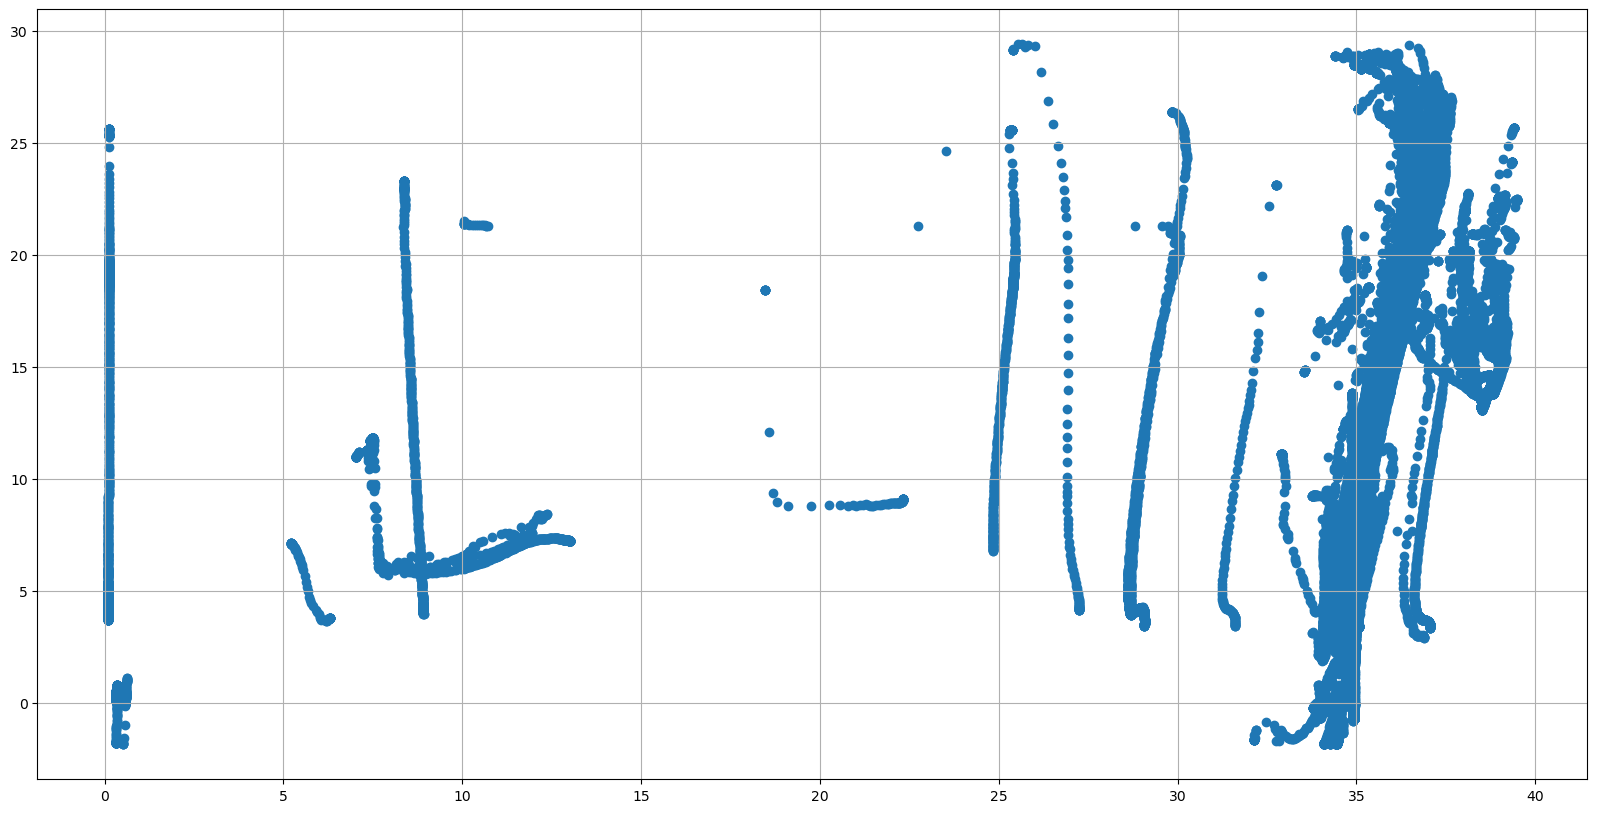

In [40]:
fig, ax = plt.subplots(figsize=(20,10))
sc = ax.scatter(dayADS.PSAL, dayADS.TEMP)
ax.grid()

some data is obviously wrong, hence, let's check if all the QC is *Good data*

In [41]:
pres=dayADS.PRES
lon=dayADS.LONGITUDE+pres*0

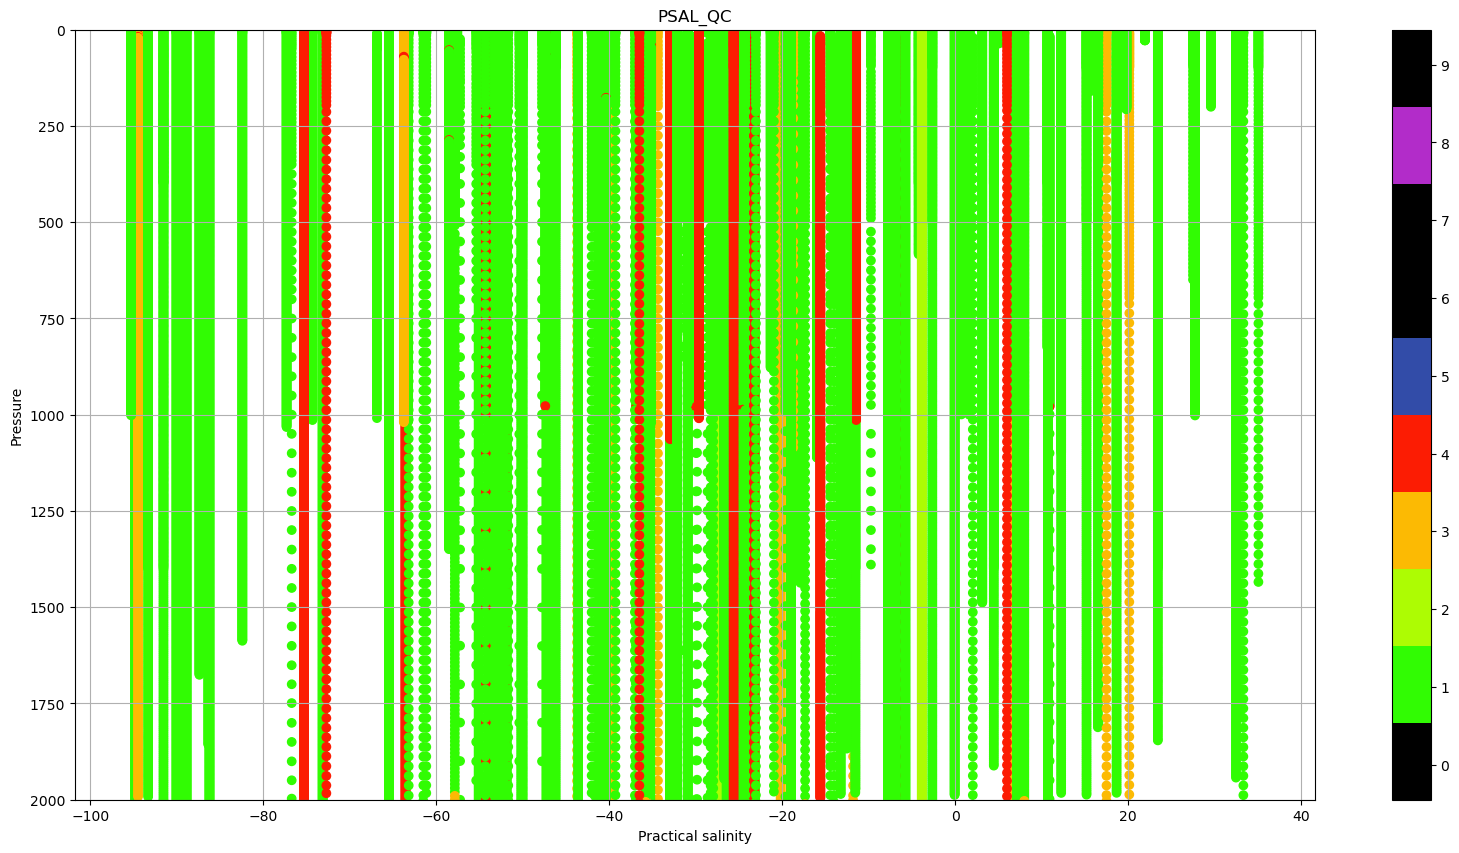

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
sc = ax.scatter(lon, pres, c=dayADS.PSAL_QC, vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax)
ax.grid()
ax.set_ylim(0,2000)
ax.invert_yaxis()
ax.set_xlabel(f"{dayADS.PSAL.long_name}")
ax.set_ylabel('Pressure')
ax.set_title('PSAL_QC');

There a lot of profiles with Quality Flag (QC) that indicate bada data. Now, we will plot the same TS diagram, but color coding the data bvased on the Quality flags.

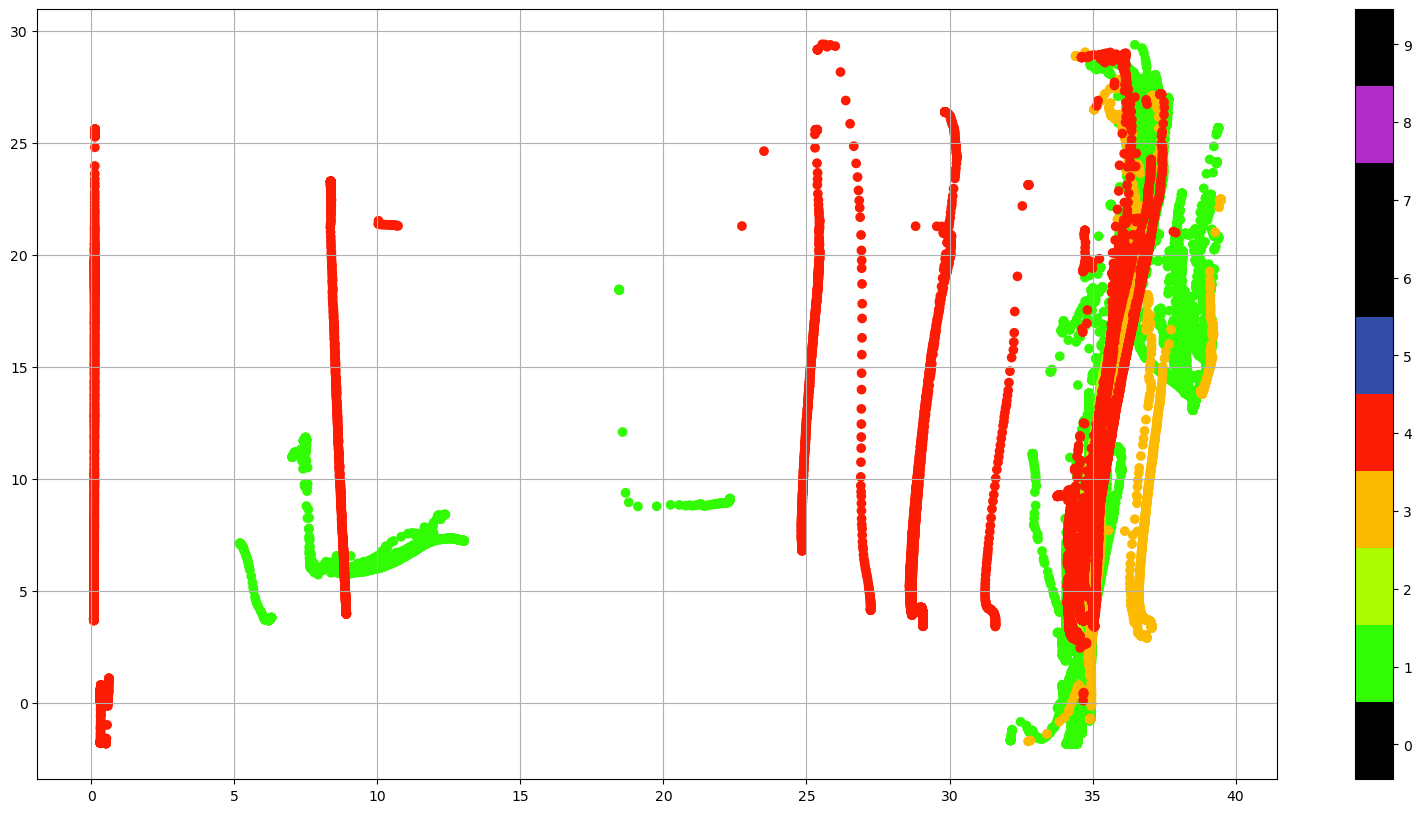

In [43]:
fig, ax = plt.subplots(figsize=(20,10))
sc = ax.scatter(dayADS.PSAL.where(dayADS.PSAL_QC.values.astype(float) == 0), 
                dayADS.TEMP.where(dayADS.PSAL_QC.values.astype(float) == 0), 
                c=dayADS.PSAL_QC.where(dayADS.PSAL_QC.values.astype(float) == 0), vmin=0, vmax=9, cmap=qcmap)

sc = ax.scatter(dayADS.PSAL.where(dayADS.PSAL_QC.values.astype(float) == 1), 
                dayADS.TEMP.where(dayADS.PSAL_QC.values.astype(float) == 1), 
                c=dayADS.PSAL_QC.where(dayADS.PSAL_QC.values.astype(float) == 1), vmin=0, vmax=9, cmap=qcmap)

sc = ax.scatter(dayADS.PSAL.where(dayADS.PSAL_QC.values.astype(float) == 2), 
                dayADS.TEMP.where(dayADS.PSAL_QC.values.astype(float) == 2), 
                c=dayADS.PSAL_QC.where(dayADS.PSAL_QC.values.astype(float) == 2), vmin=0, vmax=9, cmap=qcmap)


sc = ax.scatter(dayADS.PSAL.where(dayADS.PSAL_QC.values.astype(float) == 3), 
                dayADS.TEMP.where(dayADS.PSAL_QC.values.astype(float) == 3), 
                c=dayADS.PSAL_QC.where(dayADS.PSAL_QC.values.astype(float) == 3), vmin=0, vmax=9, cmap=qcmap)


sc = ax.scatter(dayADS.PSAL.where(dayADS.PSAL_QC.values.astype(float) == 4), 
                dayADS.TEMP.where(dayADS.PSAL_QC.values.astype(float) == 4), 
                c=dayADS.PSAL_QC.where(dayADS.PSAL_QC.values.astype(float) == 4), vmin=0, vmax=9, cmap=qcmap)

colorbar_qc(qcmap, ax=ax)
ax.grid()

Using the QC flags we could just select the good data (QC=1) or, if we are familiar with the data, we can keep all the data that could be good, (QC=0, 1, 2 or 5) and decide what to do with the suspicius data.

Addtionally there is a Global quality flag for each one of the parameters, that indicate the percentage of good data in the profile. For salinitiy this global quality flag is PROFILE_PSAL_QC and it


|    Flag   | Description |
| --------- | ----------- |
| A         |        N = 100% , all profile levels contain good data  |
| B         | 75% <= N < 100% |
| C         | 75% <= N < 100% |
| D         | 75% <= N < 100% |
| E         | 75% <= N < 100% |
| F         |        N = 0%, no profile levels have good data|


A N = 100%; All profile levels contain good data.
B 75% <= N < 100%
C 50% <= N < 75%
D 25% <= N < 50%
E 0% < N < 25%


Example :
PROFILE_TEMP_QC = A : the temperature
profile contains only good values
 = C : the salinity profile
contains 50% to 75% good values




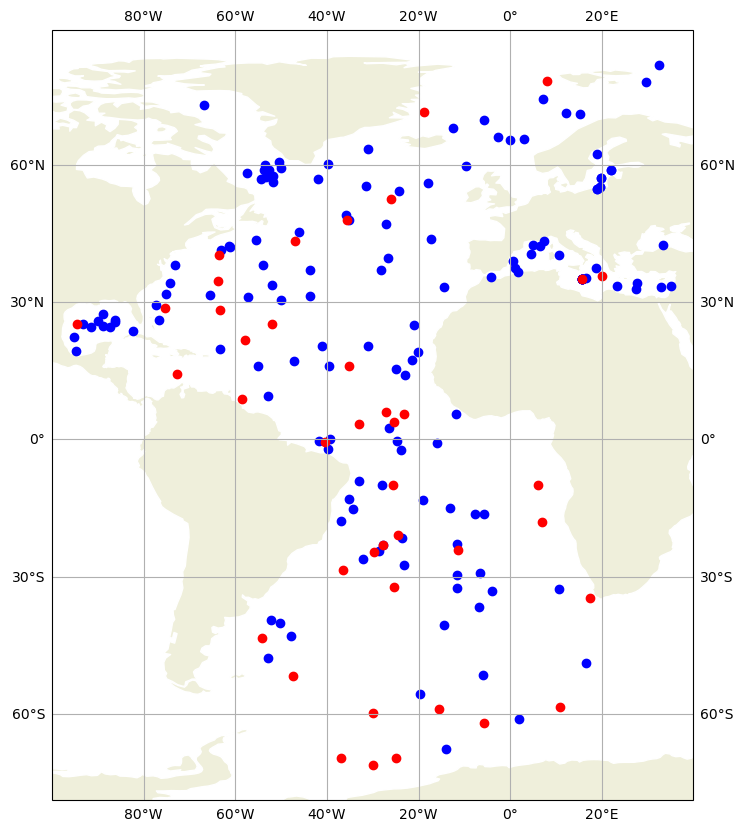

In [44]:
dayADS.LONGITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'A')

fig,ax = plt.subplots(figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax.plot(dayADS.LONGITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'A'), 
        dayADS.LATITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'A'),
        'ob')

ax.plot(dayADS.LONGITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'B'), 
        dayADS.LATITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'B'),
        'or')

ax.plot(dayADS.LONGITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'C'), 
        dayADS.LATITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'D'),
        'or')
ax.plot(dayADS.LONGITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'E'), 
        dayADS.LATITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'E'),
        'or')
ax.plot(dayADS.LONGITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'F'), 
        dayADS.LATITUDE.where(dayADS.PROFILE_PSAL_QC.values.astype(str) == 'F'),
        'or')

#ax.set_title(f"Data from {Rtraj.PLATFORM_NUMBER.values.astype(str)}")
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.COASTLINE, edgecolor='white')

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_xlim([-100, 40]);  

## QC flags for data accessed by float

In [48]:
#iwmo = 1900379
iwmo = 6900230
file = f"../.././Data/{iwmo}/{iwmo}_prof.nc"
dayADS = xr.open_dataset(file)

In [49]:
dayADS

<xarray.Dataset> Size: 467kB
Dimensions:                       (N_PROF: 73, N_PARAM: 3, N_LEVELS: 72,
                                   N_CALIB: 1, N_HISTORY: 0)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB, N_HISTORY
Data variables: (12/64)
    DATA_TYPE                     object 8B ...
    FORMAT_VERSION                object 8B ...
    HANDBOOK_VERSION              object 8B ...
    REFERENCE_DATE_TIME           object 8B ...
    DATE_CREATION                 object 8B ...
    DATE_UPDATE                   object 8B ...
    ...                            ...
    HISTORY_ACTION                (N_HISTORY, N_PROF) object 0B ...
    HISTORY_PARAMETER             (N_HISTORY, N_PROF) object 0B ...
    HISTORY_START_PRES            (N_HISTORY, N_PROF) float32 0B ...
    HISTORY_STOP_PRES             (N_HISTORY, N_PROF) float32 0B ...
    HISTORY_PREVIOUS_VALUE        (N_HISTORY, N_PROF) float32 0B ...
    HISTORY_QCTEST                (N_HISTORY, N_PROF) object 0B ...
Attributes:
    title:                Argo float vertical profile
    institution:          FR GDAC
    source:               Argo float
    history:              2019-12-09T13:15:39Z creation
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  3.1
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile

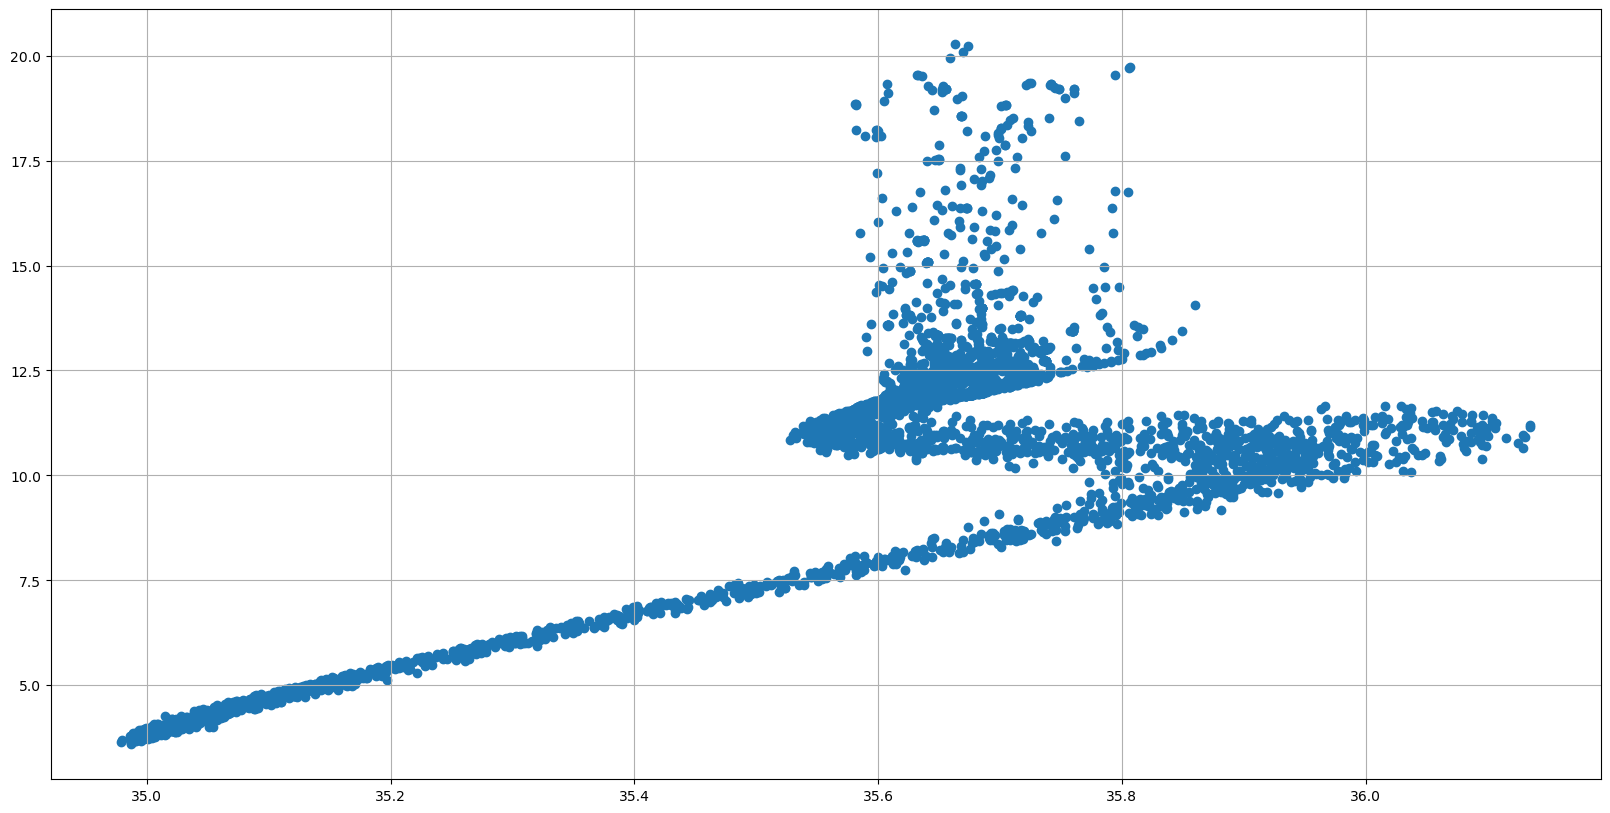

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
sc = ax.scatter(dayADS.PSAL, dayADS.TEMP)
ax.grid()

In [52]:
pres=dayADS.PRES
cycle=dayADS.CYCLE_NUMBER+pres*0

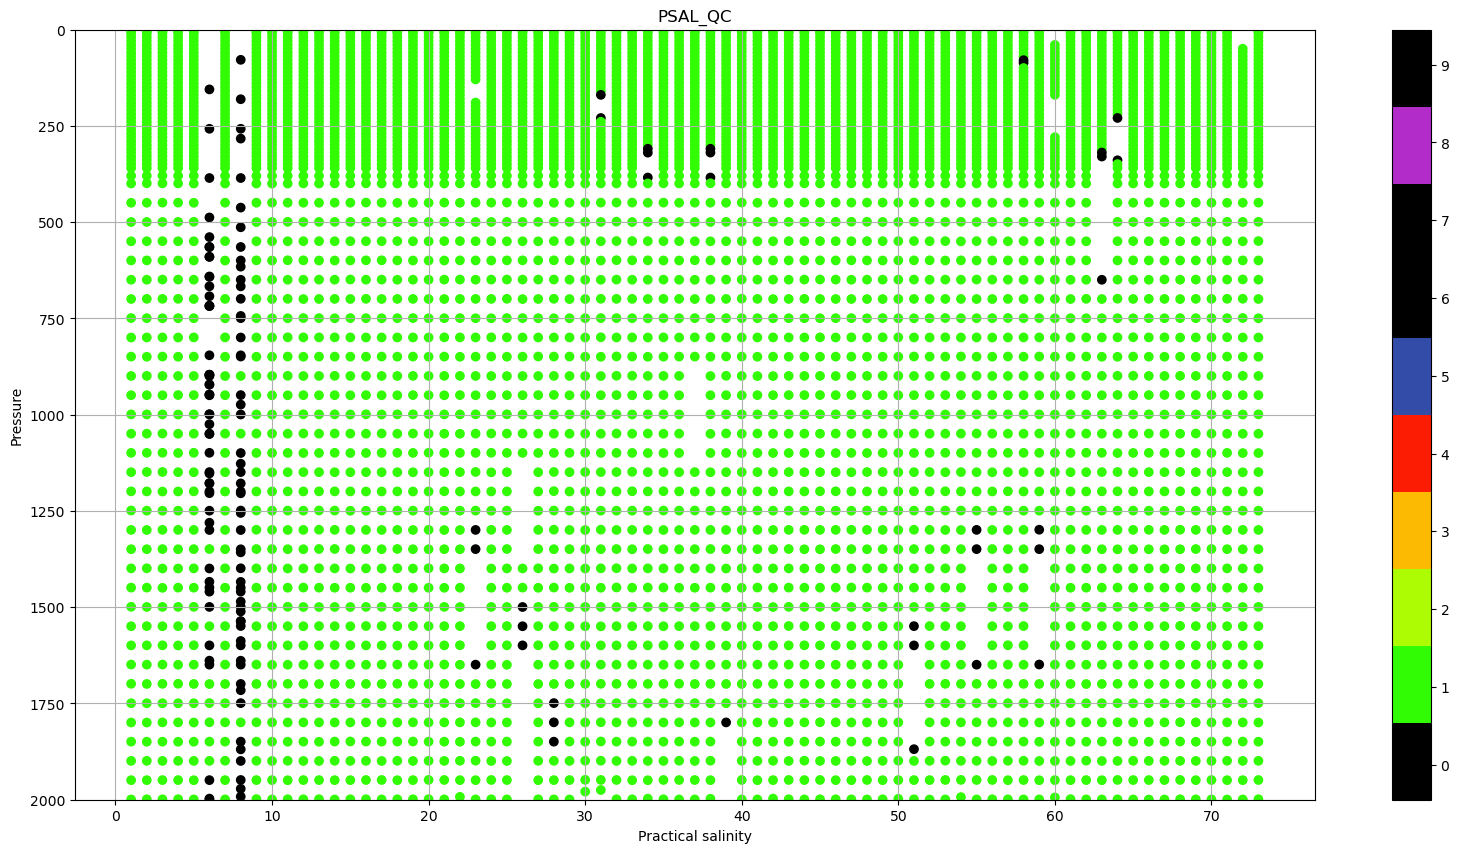

In [53]:
fig, ax = plt.subplots(figsize=(20,10))
sc = ax.scatter(cycle, pres, c=dayADS.PSAL_QC, vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax)
ax.grid()
ax.set_ylim(0,2000)
ax.invert_yaxis()
ax.set_xlabel(f"{dayADS.PSAL.long_name}")
ax.set_ylabel('Pressure')
ax.set_title('PSAL_QC');  